# HDFS mask generation logbook
This Notebook generates the HDFS phase masks. It uses the class **HDFSmaskGenerator** available in CEO/python/ceo/sensors/

The masks are saved in the CEO/python/ceo/sensors in FITS format, and the files are named following the convention: **ngws_hdfs_phase_design_XXX.fits** where **XXX** is a suffix that identifies the particular mask design. The following designs are available as to date:
1. **v1**: The original HDFS mask designed by S. Haffert and delivered to GMTO. This mask was used for all simulation results up to the NSF review (Dec 2022).
2. **v2a**: Mask A in FWN126. Design optimized by S. Haffert and fine-tuned by M. van Dam. (HDFS mask baseline design from Jan 2023).
3. **v2b**: Mask B in FWN126. Design optimized by S. Haffert.
4. **S3m**: Mask designed for an incomplete GMT pupil with an off-axis segment missing. Segments present: [S0,S1,S2,S4,S5,S6].

Last update: 01/03/2023 (fquiros)

In [1]:
# NOTE: ordering of the GMT segments (for angle = 0) as seen by plt.imshow()
#        3
#    4       2
#        6 
#    5       1 
#        0

In [1]:
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt
import ceo
%matplotlib inline

/home/ubuntu/CEO/python/ceo/zemax


In [2]:
from HDFSmaskGenerator import HDFSmaskGenerator
import astropy.io.fits as fits

## Initializations

### Routines for fringes visualization

In [3]:
gmt = ceo.GMT_MX()
D = 25.5                # [m] Diameter of simulated square (slightly larger than GMT diameter) 
nPx = 512
gs = ceo.Source('V', rays_box_size=D, rays_box_sampling=nPx, rays_origin=[0.0,0.0,25])

In [4]:
gs.reset()
gmt.reset()
gmt.propagate(gs)
maskPup = gs.amplitude.host()
P = np.squeeze(np.array(gs.rays.piston_mask))
norm_pup = np.sum(gs.amplitude.host())**2

In [5]:
# -- Broadband PSF: select band, and assume top-hat transmission
HDFS_band = [700e-9, 920e-9]
bbpsf = ceo.BBPSF(maskPup, wvl_band=HDFS_band, wvl_res=10e-9, D=D, fov_mas=2000)

In [6]:
#------------------- Function to show PSF
#   im_display_size: +/- mas from center
def show_psf(myPSF, im_display_size=150, clim=[-8,0], fig=None,ax1=None):
    if ax1==None:
        fig, ax1 = plt.subplots()
        fig.set_size_inches(7,5)
        fig.dpi=100
        
    im_range_mas = np.array([-im_display_size, im_display_size])
    im_range_pix = np.rint(im_range_mas/bbpsf._fp_pxscl_mas + bbpsf._im_sz/2).astype(int)

    imm = ax1.imshow(np.log10(myPSF[im_range_pix[0]:im_range_pix[1],im_range_pix[0]:im_range_pix[1]]), 
                     extent=[-im_display_size,im_display_size,-im_display_size,im_display_size], 
                     origin='lower', interpolation='None')
    clb = fig.colorbar(imm, ax=ax1)
    imm.set_clim(clim)
    ax1.set_xlabel('mas')

### Verify segment baselines
Baselines are computed assuming the center-to-center distance between any outer and central segment is 8.710 m. As shown below, the estimate of this distance from the GMT pupil image is smaller. Since the baseline is used to compute the position of the sidelobe in the FFTlet images, we verified that the nominal value of 8.710 m provides the correct estimate of the sidelobe peak.

In [7]:
vv = np.linspace(-1,1,nPx)*(D/2)
[x_ep,y_ep] = np.meshgrid(vv,vv) # rows x cols
x_ep1 = x_ep.ravel()
y_ep1 = y_ep.ravel()
seg_xc = []
seg_yc = []
for segmask in P:
    seg_xc += [np.mean(x_ep1[segmask])]
    seg_yc += [np.mean(y_ep1[segmask])]

# center-to-center distance between outer and central segment
segdi = [np.sqrt((xc-seg_xc[-1])**2 + (yc-seg_yc[-1])**2) for xc, yc in zip(seg_xc, seg_yc)] 
segai = np.arctan2(np.array(seg_xc[0:-1]), np.array(seg_yc[0:-1]) )*180/np.pi

In [8]:
print('Mean separation between central segment and outer segments: %0.3f m'%np.mean(segdi[0:-1]))

Mean separation between central segment and outer segments: 8.656 m


In [9]:
def positive_angle(vec):
    vec = np.where(vec < 0, (vec+360), vec)
    return vec

print('Angular position of outer segments: '+np.array_str(positive_angle(np.round(segai))))

Angular position of outer segments: [ -0.  60. 120. 180. 240. 300.]


## HDFS mask design v 1.0
This mask was originally designed by S. Haffert and provided to GMTO for HDFS simulations.
It produces two pair of fringes at same locations in the focal plane. They need an angular offset applied.

In [39]:
HDFS_file = fits.open('ngws_hdfs_phase_design_v1_orig.fits')
HDFS_file.info()
HDFSmask_orig = (HDFS_file[0].data).astype('float')
HDFS_file.close()

Filename: ngws_hdfs_phase_design_v1_orig.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (512, 512)   float64   


### Mask re-generation
Below we regenerated the mask above, using the newly available **HDFSmaskGenerator** class. Note that the grating patterns have a random phase component, so we cannot exactly reproduce the original mask.

In [40]:
segment_sequence_v1 = [6,0,3,1,4,2,5]
maskgen1 = HDFSmaskGenerator(segment_sequence_v1)

pair	baseline	angle	offset
S6-S0:	8.7 m		90	0.0
S0-S3:	17.4 m		90	0.0
S3-S1:	15.1 m		60	0.0
S1-S4:	17.4 m		30	0.0
S4-S2:	15.1 m		0	0.0
S2-S5:	17.4 m		150	0.0
S5-S6:	8.7 m		150	0.0

****Warning****
Duplicate angles dectected! Fringes need offset!


In [41]:
#-- Offsets applied to grating default orientations
offset_deg = 5.5
offset = np.array([offset_deg, -offset_deg, 0.0, 0.0, 0.0, -offset_deg, offset_deg])

#-- Cycles per pupil of grating patterns
cycles_per_pupil = 80.

#-- Create phase mask
maskgen1.make_mask_phase(offset, cycles_per_pupil, npix=nPx, Dtel=D, use_blazed=False, make_binary=True)

#-- Check final mask configuration
maskgen1.pairs_summary()

pair	baseline	angle	offset
S6-S0:	8.7 m		90	5.5
S0-S3:	17.4 m		90	-5.5
S3-S1:	15.1 m		60	0.0
S1-S4:	17.4 m		30	0.0
S4-S2:	15.1 m		0	0.0
S2-S5:	17.4 m		150	-5.5
S5-S6:	8.7 m		150	5.5


### Compare original and regenerated masks

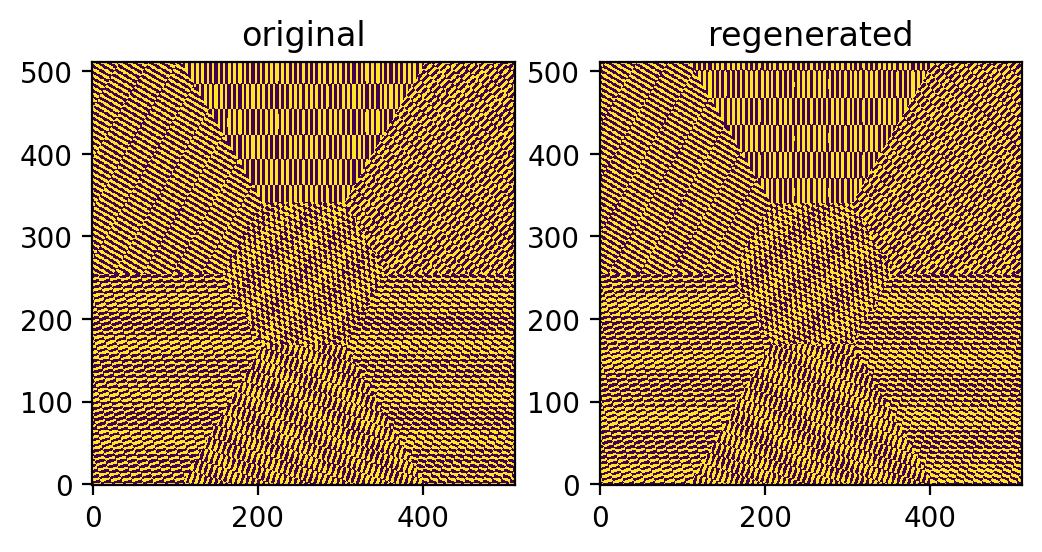

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.dpi=200

im1 = ax1.imshow(HDFSmask_orig, origin='lower', interpolation='none')
ax1.set_title('original')
#clb1 = fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(maskgen1.HDFSmask, origin='lower', interpolation='none')
ax2.set_title('regenerated');
#clb2 = fig.colorbar(im, ax=ax2)

### Show the fringes

In [43]:
#------ Fringe for flat WF
cwvl = 795e-9
fringes1 = bbpsf.propagate(maskgen1.HDFSmask*(cwvl/(2*np.pi)))
fringes_orig = bbpsf.propagate(HDFSmask_orig*(cwvl/(2*np.pi)))

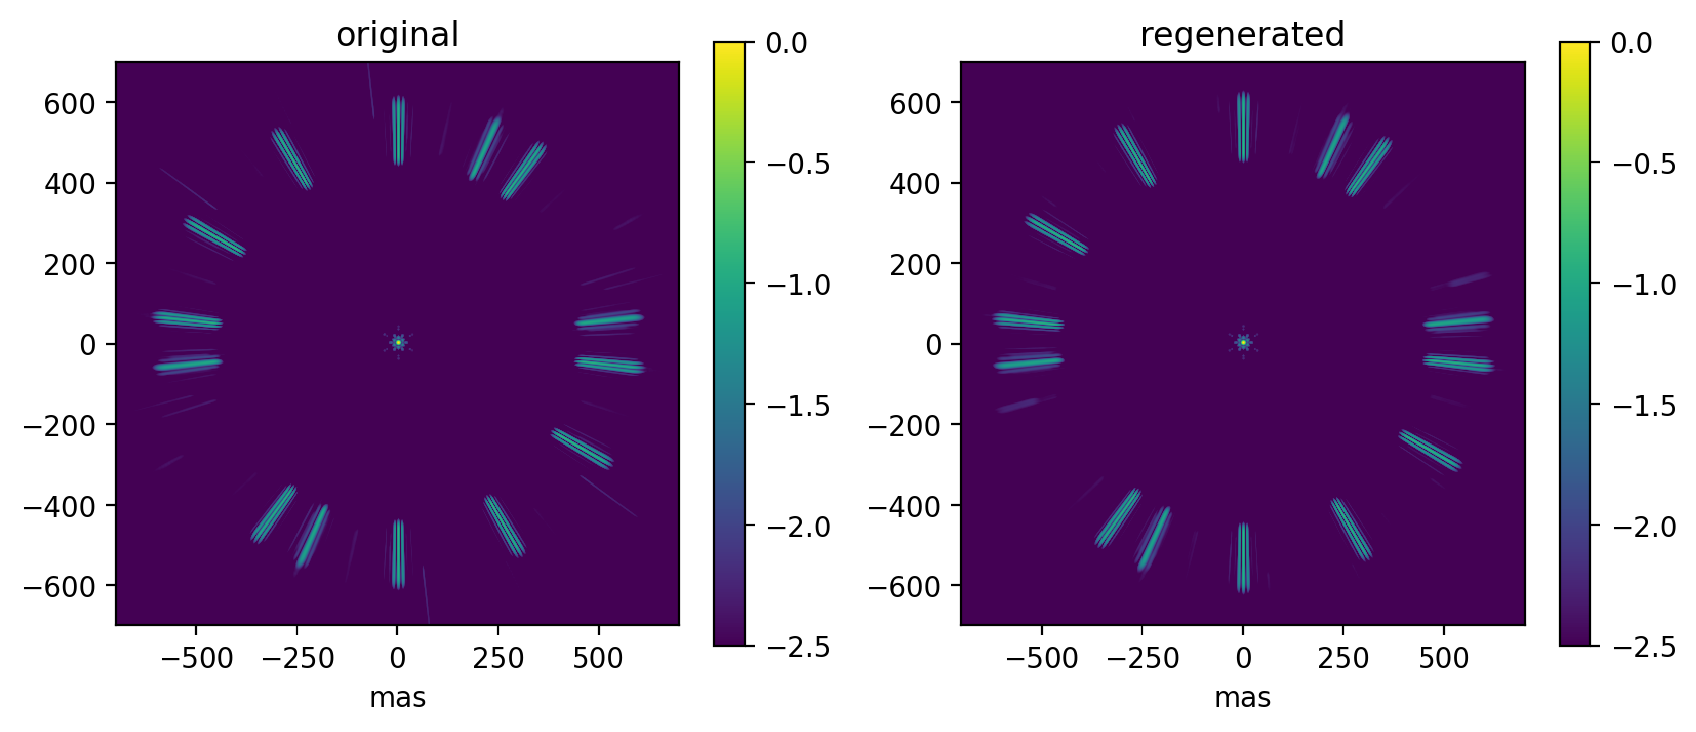

In [44]:
fig, (ax2, ax1) = plt.subplots(ncols=2)
fig.set_size_inches((10,4))
fig.dpi = 200
show_psf((fringes1/cp.max(fringes1)).get(), im_display_size=700, clim=[-2.5,0], fig=fig, ax1=ax1)
ax1.set_title('regenerated')
show_psf((fringes_orig/cp.max(fringes_orig)).get(), im_display_size=700, clim=[-2.5,0], fig=fig, ax1=ax2)
ax2.set_title('original');

### Save to FITS

In [46]:
#----- Save to FITS file
maskgen1.save_mask_fits('ngws_hdfs_phase_design_v1')#, overwrite=True)

--->>> HDFS mask data successfully written to FITS file: /home/ubuntu/CEO/python/ceo/sensors/ngws_hdfs_phase_design_v1.fits
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  MASK          1 PrimaryHDU      11   (512, 512)   float64   
  1  PAIRS         1 ImageHDU         8   (2, 7)   int64   
  2  BASELINE      1 ImageHDU         7   (7,)   float64   
  3  ANGLE         1 ImageHDU         7   (7,)   float64   
  4  OFFSET        1 ImageHDU         7   (7,)   float64   


## HDFS mask design v 2.0a
This mask was originally designed by S. Haffert and fine-tuned by Marcos van Dam (see Mask A in FWN126).
It produces one pair of fringes at the same location in the focal plane. Those need an angular offset applied.

In [10]:
segment_sequence_v2a = [6,0,1,3,5,2,4]
maskgen2a = HDFSmaskGenerator(segment_sequence_v2a)

pair	baseline	angle	offset
S6-S0:	8.7 m		90	0.0
S0-S1:	8.7 m		150	0.0
S1-S3:	15.1 m		60	0.0
S3-S5:	15.1 m		120	0.0
S5-S2:	17.4 m		150	0.0
S2-S4:	15.1 m		0	0.0
S4-S6:	8.7 m		30	0.0

****Warning****
Duplicate angles dectected! Fringes need offset!


In [12]:
#-- Offsets applied to grating default orientations
offset_deg = 7.5
offset = np.array([0.0, offset_deg, 0.0, 0.0, -offset_deg, 0.0, 0.0])

#-- Cycles per pupil of grating patterns
cycles_per_pupil = 50.

#-- Create phase mask
maskgen2a.make_mask_phase(offset, cycles_per_pupil, npix=nPx, Dtel=D, use_blazed=False, make_binary=True)

#-- Check final mask configuration
maskgen2a.pairs_summary()

pair	baseline	angle	offset
S6-S0:	8.7 m		90	0.0
S0-S1:	8.7 m		150	7.5
S1-S3:	15.1 m		60	0.0
S3-S5:	15.1 m		120	0.0
S5-S2:	17.4 m		150	-7.5
S2-S4:	15.1 m		0	0.0
S4-S6:	8.7 m		30	0.0


### Show the fringes

In [13]:
#------ Compute the fringes for a flat WF
cwvl = 780e-9  #wavelength at which the phase mask is defined.
fringes2a = bbpsf.propagate(maskgen2a.HDFSmask*(cwvl/(2*np.pi)))

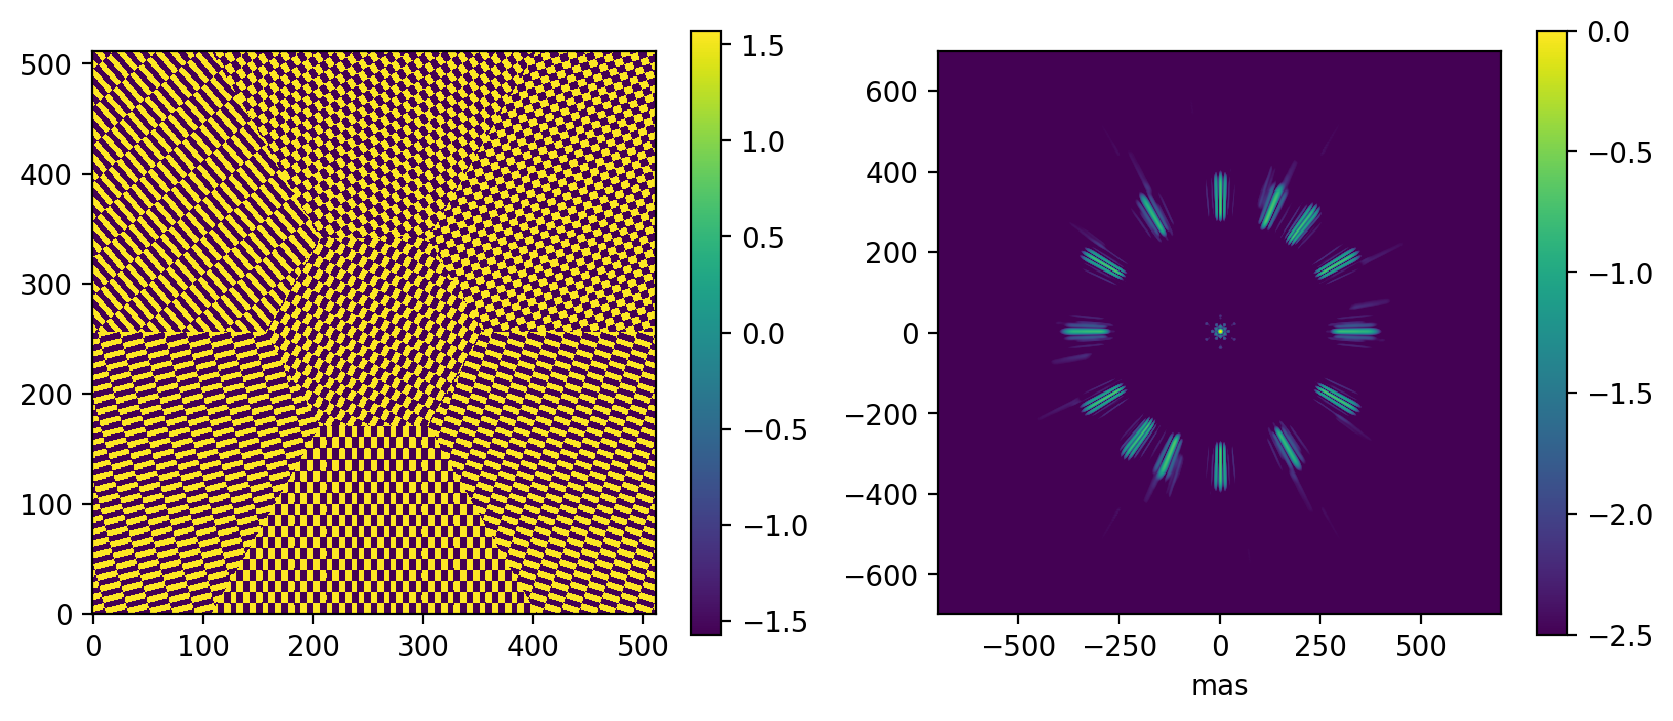

In [14]:
#------ Show the HDFS mask and the corresponding fringes
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.dpi=200
fig.set_size_inches((10,4))

im1 = ax1.imshow(maskgen2a.HDFSmask, origin='lower', interpolation='none')
clb1 = fig.colorbar(im1, ax=ax1)
show_psf((fringes2a/cp.max(fringes2a)).get(), im_display_size=700, clim=[-2.5,0], fig=fig, ax1=ax2)

### Save to FITS

In [15]:
#----- Save to FITS file
maskgen2a.save_mask_fits('ngws_hdfs_phase_design_v2a')#, overwrite=True)

--->>> HDFS mask data successfully written to FITS file: /home/ubuntu/CEO/python/ceo/sensors/ngws_hdfs_phase_design_v2a.fits
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  MASK          1 PrimaryHDU      11   (512, 512)   float64   
  1  PAIRS         1 ImageHDU         8   (2, 7)   int64   
  2  BASELINE      1 ImageHDU         7   (7,)   float64   
  3  ANGLE         1 ImageHDU         7   (7,)   float64   
  4  OFFSET        1 ImageHDU         7   (7,)   float64   


## HDFS mask design v 2.0b
This mask was originally designed by S. Haffert (see Mask B in FWN126).
It produces one pair of fringes at the same location in the focal plane. Those need an angular offset applied.

In [16]:
segment_sequence_v2b = [6,0,2,4,1,3,5]
maskgen2b = HDFSmaskGenerator(segment_sequence_v2b)

pair	baseline	angle	offset
S6-S0:	8.7 m		90	0.0
S0-S2:	15.1 m		120	0.0
S2-S4:	15.1 m		0	0.0
S4-S1:	17.4 m		30	0.0
S1-S3:	15.1 m		60	0.0
S3-S5:	15.1 m		120	0.0
S5-S6:	8.7 m		150	0.0

****Warning****
Duplicate angles dectected! Fringes need offset!


In [17]:
#-- Offsets applied to grating default orientations
offset_deg = 7.5
offset = np.array([0.0, offset_deg, 0.0, 0.0, 0.0, -offset_deg, 0.0])

#-- Cycles per pupil of grating patterns
cycles_per_pupil = 50.

#-- Create phase mask
maskgen2b.make_mask_phase(offset, cycles_per_pupil, npix=nPx, Dtel=D, use_blazed=False, make_binary=True)

#-- Check final mask configuration
maskgen2b.pairs_summary()

pair	baseline	angle	offset
S6-S0:	8.7 m		90	0.0
S0-S2:	15.1 m		120	7.5
S2-S4:	15.1 m		0	0.0
S4-S1:	17.4 m		30	0.0
S1-S3:	15.1 m		60	0.0
S3-S5:	15.1 m		120	-7.5
S5-S6:	8.7 m		150	0.0


### Show the fringes

In [20]:
#------ Compute the fringes for a flat WF
cwvl = 780e-9  #wavelength at which the phase mask is defined.
fringes2b = bbpsf.propagate(maskgen2b.HDFSmask*(cwvl/(2*np.pi)))

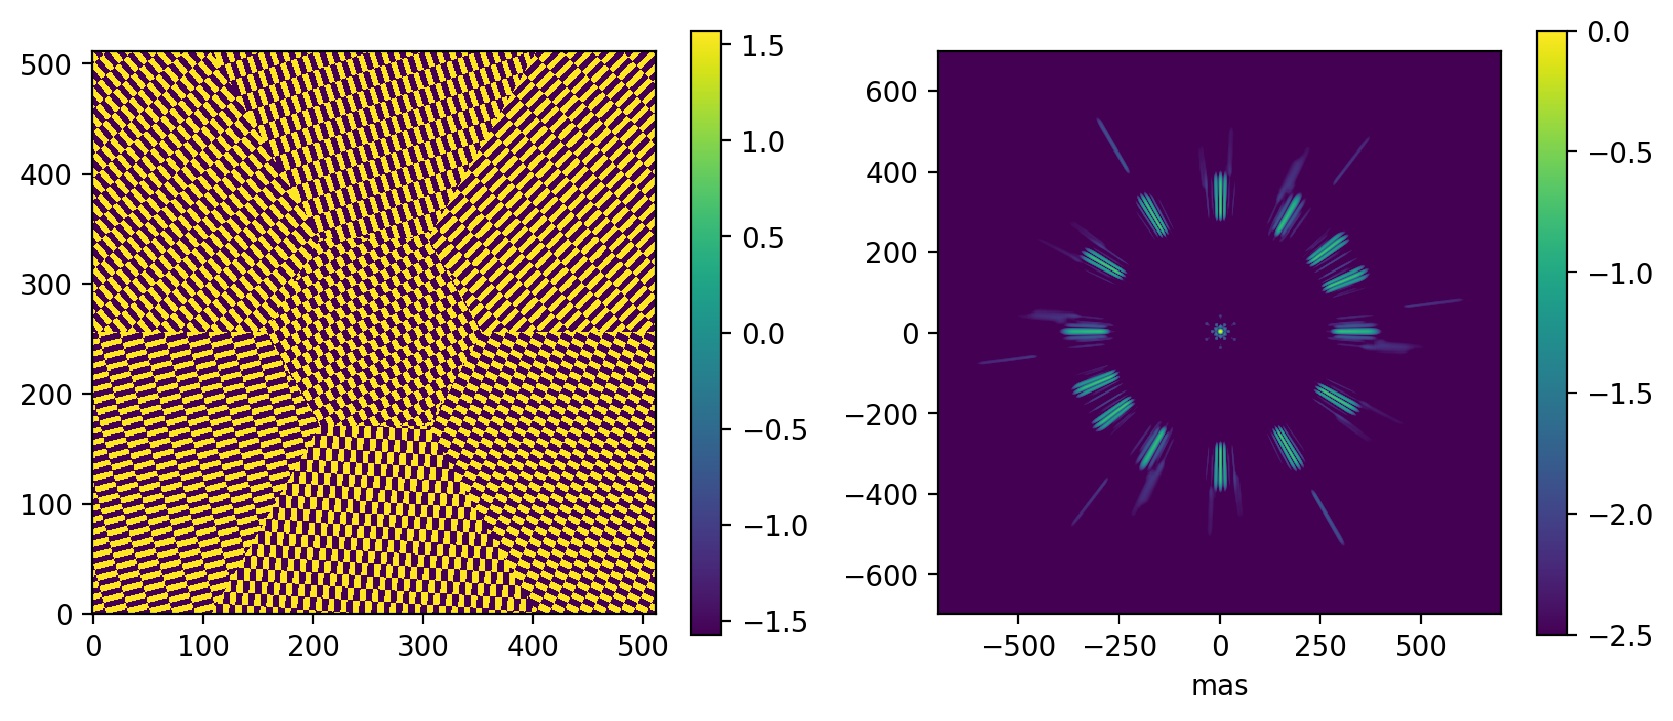

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.dpi=200
fig.set_size_inches((10,4))

im1 = ax1.imshow(maskgen2b.HDFSmask, origin='lower', interpolation='none')
clb1 = fig.colorbar(im1, ax=ax1)
show_psf((fringes2b/cp.max(fringes2b)).get(), im_display_size=700, clim=[-2.5,0], fig=fig, ax1=ax2)

### Save to FITS

In [22]:
#----- Save to FITS file
maskgen2b.save_mask_fits('ngws_hdfs_phase_design_v2b')#, overwrite=True)

--->>> HDFS mask data successfully written to FITS file: /home/ubuntu/CEO/python/ceo/sensors/ngws_hdfs_phase_design_v2b.fits
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  MASK          1 PrimaryHDU      11   (512, 512)   float64   
  1  PAIRS         1 ImageHDU         8   (2, 7)   int64   
  2  BASELINE      1 ImageHDU         7   (7,)   float64   
  3  ANGLE         1 ImageHDU         7   (7,)   float64   
  4  OFFSET        1 ImageHDU         7   (7,)   float64   


## HDFS mask design with one outer segment missing
Segment missing: S3. However, this mask could be used in principle when any outer segment is missing by applying a physical rotation.

In [1]:
# NOTE: ordering of the GMT segments (for angle = 0) as seen by plt.imshow()
#        3
#    4       2
#        6 
#    5       1 
#        0

In [24]:
segment_sequence_vS3m = [6,1,5,4,0,2]
maskgen3 = HDFSmaskGenerator(segment_sequence_vS3m)

pair	baseline	angle	offset
S6-S1:	8.7 m		30	0.0
S1-S5:	15.1 m		0	0.0
S5-S4:	8.7 m		90	0.0
S4-S0:	15.1 m		60	0.0
S0-S2:	15.1 m		120	0.0
S2-S6:	8.7 m		150	0.0


In [26]:
#-- Offsets applied to grating default orientations
offset = np.zeros(6)

#-- Cycles per pupil of grating patterns
cycles_per_pupil = 50.

#-- Create phase mask
maskgen3.make_mask_phase(offset, cycles_per_pupil, npix=nPx, Dtel=D, use_blazed=False, make_binary=True)

#-- Check final mask configuration
maskgen3.pairs_summary()

pair	baseline	angle	offset
S6-S1:	8.7 m		30	0.0
S1-S5:	15.1 m		0	0.0
S5-S4:	8.7 m		90	0.0
S4-S0:	15.1 m		60	0.0
S0-S2:	15.1 m		120	0.0
S2-S6:	8.7 m		150	0.0


### Show the fringes

In [28]:
#------ Compute the fringes for a flat WF
cwvl = 780e-9  #wavelength at which the phase mask is defined.
fringes3 = bbpsf.propagate(maskgen3.HDFSmask*(cwvl/(2*np.pi)))

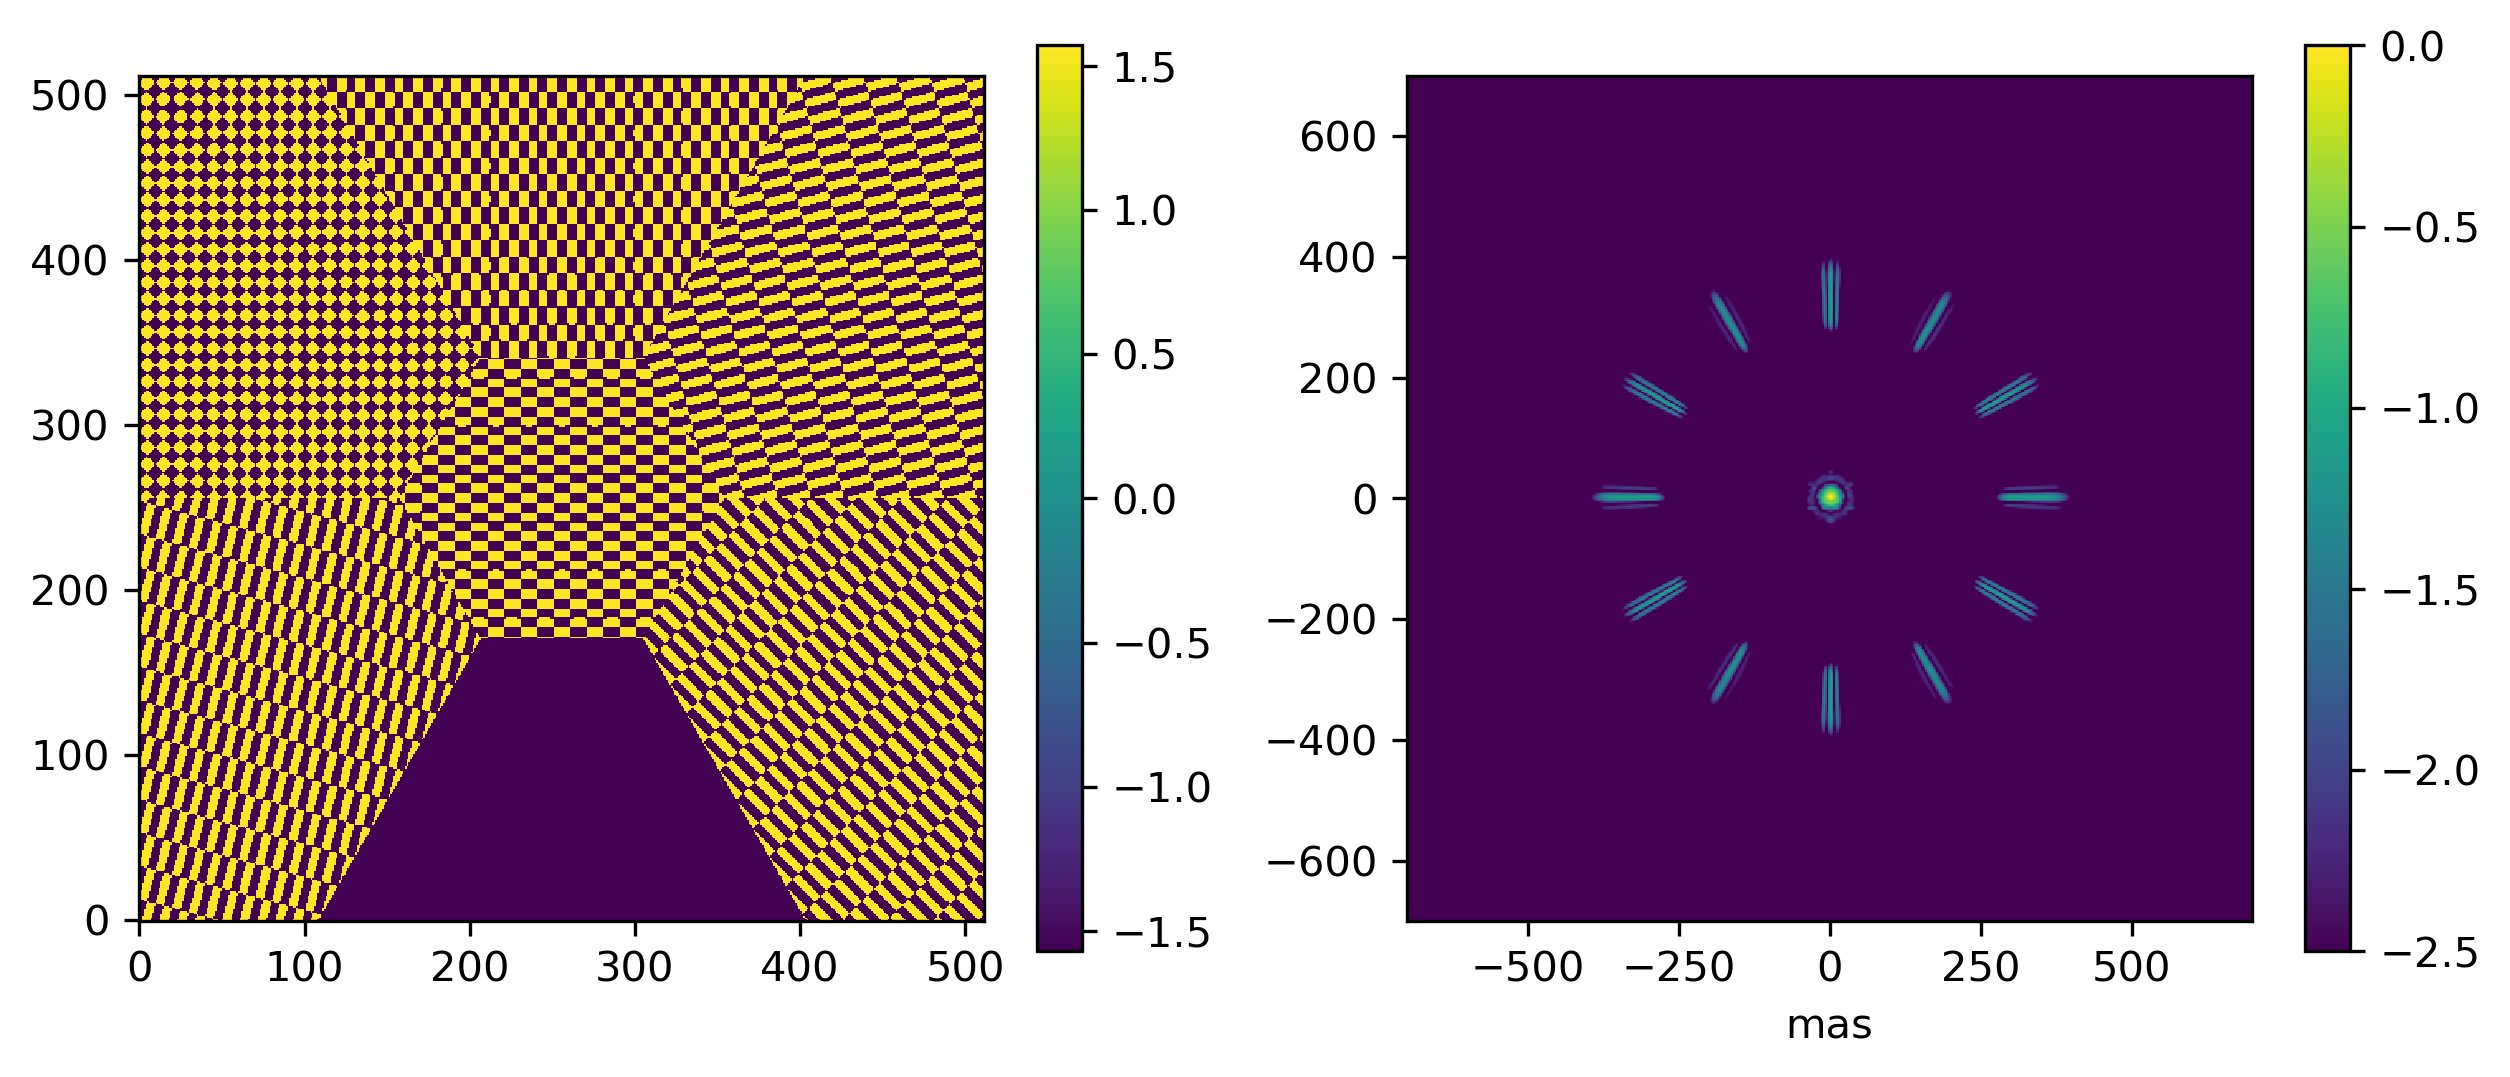

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.dpi=300
fig.set_size_inches((10,4))

im1 = ax1.imshow(maskgen3.HDFSmask, origin='lower', interpolation='none')
clb1 = fig.colorbar(im1, ax=ax1)
show_psf((fringes3/cp.max(fringes3)).get(), im_display_size=700, clim=[-2.5,0], fig=fig, ax1=ax2)

### Save to FITS

In [30]:
#----- Save to FITS file
maskgen3.save_mask_fits('ngws_hdfs_phase_design_S3m')#, overwrite=True)

--->>> HDFS mask data successfully written to FITS file: /home/ubuntu/CEO/python/ceo/sensors/ngws_hdfs_phase_design_S3m.fits
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  MASK          1 PrimaryHDU      11   (512, 512)   float64   
  1  PAIRS         1 ImageHDU         8   (2, 6)   int64   
  2  BASELINE      1 ImageHDU         7   (6,)   float64   
  3  ANGLE         1 ImageHDU         7   (6,)   float64   
  4  OFFSET        1 ImageHDU         7   (6,)   float64   
